In [1]:
from __future__ import print_function
import pickle 
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

%matplotlib inline

## Load Data

In [2]:
use_cuda = False
momentum_par = 0.5
lr = 0.01
log_interval = 10
epochs = 500

In [3]:
torch.manual_seed(42)

In [4]:
trainset_labeled = pickle.load(open("data/train_labeled.p", "rb"))

Files already downloaded
3000
750


In [5]:
validset = pickle.load(open("data/validation.p", "rb"))

In [11]:
def imshow(img):
    if type(img) == torch.FloatTensor:
        npimg = img.numpy()
    else:
        npimg = img
    plt.imshow(np.transpose(npimg, (1, 2, 0))[:,:,0], 
               cmap='gray')

## Translate

In [6]:
data = trainset_labeled.train_data.numpy()

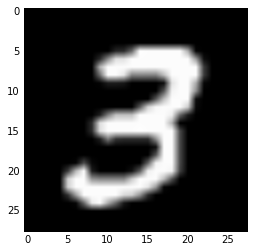

In [19]:
plt.imshow(data[900], cmap='gray')

In [101]:
foo=data[900]

In [115]:
def translate(foo,output,x,y,x_flip,y_flip):
    if x_flip:
        foo=np.fliplr(foo)
    if y_flip:
        foo = np.flipud(foo)

    foo=foo[x:,y:]
    foo = np.append(foo,np.zeros((x,28-y)),axis=0)
    foo = np.append(foo,np.zeros((28,y)),axis=1)

    if x_flip:
        foo=np.fliplr(foo)
    if y_flip:
        foo = np.flipud(foo)
    output.append(foo)

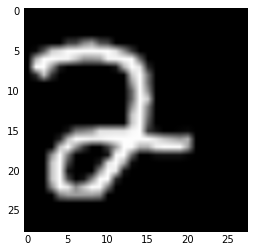

In [143]:
output1=[]
i=777
(x,y,x_flip,y_flip) = (0,4,False,False)
translate(data[i],output1,x,y,x_flip,y_flip)
plt.imshow(output1[0], cmap='gray')

In [144]:
output1[0].shape

(28, 28)

In [145]:
output=[]
for data_point in data:
    for x in [0,2,4]:
        for y in [0,2,4]:
            for x_flip in [True,False]:
                for y_flip in [True,False]:
                    translate(data_point, output, x, y, x_flip, y_flip)

output = np.array(output)
output = output.reshape(output.shape[0],1,28,28)

In [154]:
labels = np.arange(108000)/(3*3*2*2*300)

In [158]:
pickle.dump(output,file('./data/translated_train.p','wb'))

In [160]:
pickle.dump(labels,file('./data/translated_train_labels.p','wb'))

## ZCA

In [306]:
def zca_whitening(train_data, epsilon=1, valid_data=None):
    #Epsilon is whitening constant, and prevents division by zero
    
    data = train_data.numpy()
    orig_shape = data.shape
    data = data.reshape(data.shape[0],data.shape[1]*data.shape[2])
    
    # Correlation matrix requires zero-mean
    mu = np.mean(data, axis=0)
    data=(data-mu).T

    sigma = np.dot(data, data.T)/data.shape[1] #Correlation matrix
    U,S,_ = np.linalg.svd(sigma) #Singular Value Decomposition
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(S + epsilon))), U.T)  #ZCA Whitening matrix
    
    whitened_train_data = np.dot(ZCAMatrix, data).T.reshape(orig_shape)
    
    if type(valid_data)==type(None):
        whitened_valid_data=None
    else:
        valid_data=valid_data.numpy()
        orig_valid_shape = valid_data.shape
        valid_data = valid_data.reshape(valid_data.shape[0],valid_data.shape[1]*valid_data.shape[2])
        valid_data=(valid_data-mu).T
        whitened_valid_data = np.dot(ZCAMatrix, valid_data).T.reshape(orig_valid_shape)
    
    return ZCAMatrix, whitened_train_data, whitened_valid_data

In [307]:
_, white_train_data, white_valid_data = zca_whitening(trainset_labeled.train_data, epsilon=1e-1, valid_data=validset.test_data)

In [279]:
white_train_data = torch.from_numpy(white_train_data).float()

In [280]:
white_trainset_labeled = torch.utils.data.TensorDataset(white_train_data, trainset_labeled.train_labels)

In [294]:
tempset = trainset_labeled

In [298]:
type(trainset_labeled.train_data), trainset_labeled.train_data.size()

(torch.ByteTensor, torch.Size([3000, 28, 28]))

In [300]:
type(tempset.train_data), tempset.train_data.size()

(torch.FloatTensor, torch.Size([3000, 1, 28, 28]))

In [299]:
tempset.train_data=white_train_data

In [289]:
white_trainset_labeled.target_tensor.size()

torch.Size([3000, 1])

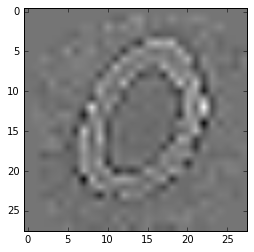

In [274]:
imshow(white_valid_data[0])

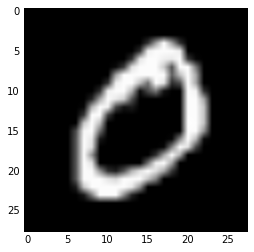

In [190]:
imshow(trainset_labeled[0][0])

-5


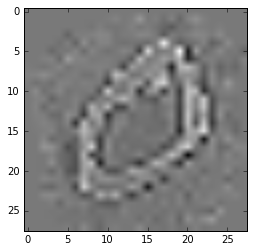

-4


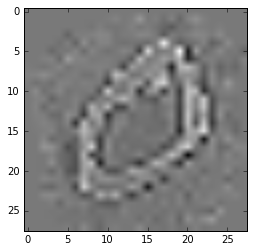

-3


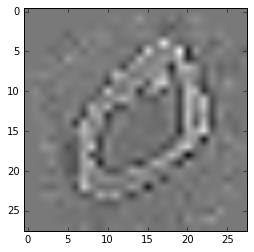

-2


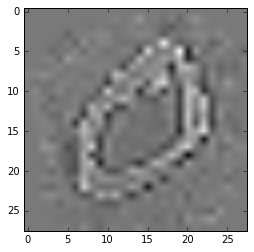

-1


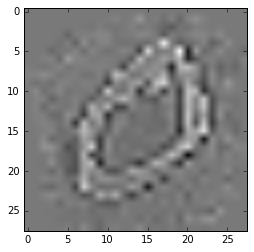

0


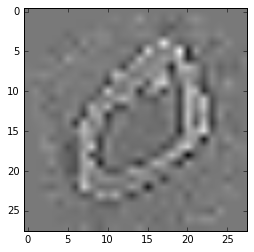

1


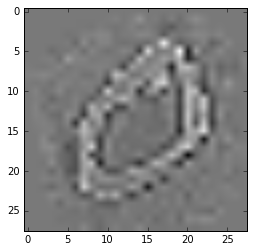

2


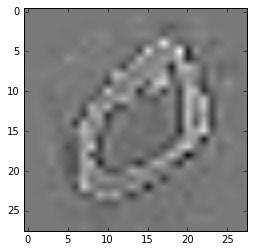

3


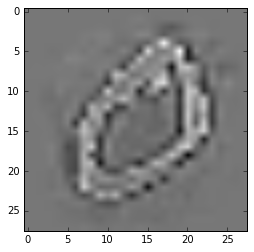

4


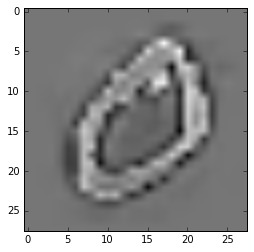

In [193]:
for i in range(-5,5):
    _, data_whitened = zca_whitening(data, epsilon=10**i)
    data_whitened = data_whitened.reshape(orig_shape)
    print(i)
    plt.imshow(data_whitened[0], cmap='gray')
    plt.show()

In [36]:
data = trainset_labeled[:,0,:,:,:].numpy()
labels = trainset_labeled[:,1,:,:].numpy()
data = data.reshape(data.shape[0], 28 * 28)

IndexError: trying to index 5 dimensions of a 3 dimensional tensor

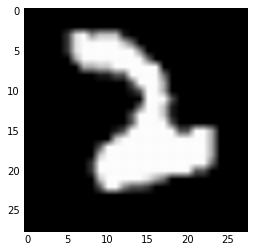

In [12]:
imshow(trainset_labeled[800][0])

Images


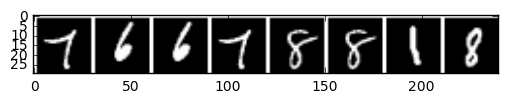

In [186]:
print("Images")
imshow(torchvision.utils.make_grid(incorrect_pixels))

In [188]:
print("Actual labels:", incorrect_outputs)

Actual labels: [9, 8, 8, 9, 3, 3, 1, 2]
